# Parameter tuning for force of mortality NN (DAV data)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.utils import shuffle
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, BatchNormalization, Dropout, Concatenate
from keras.utils import plot_model

C:\Users\liesv\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import data

In [2]:
MYwd= os.getcwd()
file_path = MYwd+"\GitHub DAV\mortality.csv"

df = pd.read_csv(file_path)

# add a column with the mortality rates (originally, only the log_mortality rates are included)
df['mortality'] = np.exp(df['log_mortality'])

# the dataset contains data from west and east germany seperately. we only use the rates for the entire population of germany (DEUT)
df = df[(df['Country'].isin(["CHE","DEUT","DNK", "ESP", "FRATNP", "ITA", "JPN", "POL", "USA"]))]

df['Gender'] = df['Gender'].astype('category').cat.codes
df['Country'] = df['Country'].astype('category').cat.codes

### Division training and test set

In [3]:
# Set up the training set
train = df[(df['Year'].between(1956, 2005))]
train = train.copy() 

# shuffle training set to get a more varied validation set
#train = shuffle(train, random_state=42)     # random_state is gelijk set.seed() (elke keer dezelfde shuffle)


# Set up the test set
test_set = df[(df['Year'].between(2006, 2016))]
test_set = test_set.copy()

## Neural network

In [4]:
# custom activation function that maps values to range [-infty, 0]

def log_sigmoid(x):
    return tf.math.log_sigmoid(x)

def negative_softplus(x):
    return -tf.math.softplus(x)

def negative_relu(x):
    return tf.minimum(0.0, x)

def scaled_log_sigmoid(x):
    return (1/5.55) * tf.math.log_sigmoid(x)

In [ ]:
year_mean, year_std = train['Year'].mean(), train['Year'].std()
age_mean, age_std = train['Age'].mean(), train['Age'].std()
gender_mean, gender_std = train['Gender'].mean(), train['Gender'].std()
country_mean, country_std = train['Country'].mean(), train['Country'].std()

In [5]:
# function to normalize and prepare the data for training

def normalize_data(data, add_country=True, add_gender=True, embed_age=False, embed_coun_gen=True):
    year = data['Year'].values.reshape(-1,1)
    age = data['Age'].values.reshape(-1,1)
    gender = data['Gender'].values.reshape(-1,1)
    country = data['Country'].values.reshape(-1,1)
    
    #year_mean, year_std = year.mean(), year.std()
    #age_mean, age_std = age.mean(), age.std()
    #gender_mean, gender_std = gender.mean(), gender.std()
    #country_mean, country_std = country.mean(), country.std()
    
    year_norm = (year - year_mean) / year_std
    age_norm = (age - age_mean) / age_std
    gender_norm = (gender - gender_mean) / gender_std
    country_norm = (country - country_mean) / country_std
    
    if add_country and add_gender:
        if embed_age and embed_coun_gen:
            X = [year_norm, age, gender, country]
        elif embed_age:
            X = [year_norm, age, gender_norm, country_norm]
        elif embed_coun_gen:
            X = [year_norm, age_norm, gender, country]
        else:
            X = [year_norm, age_norm, gender_norm, country_norm]
    elif add_country:
        if embed_age and embed_coun_gen:
            X = [year_norm, age, country]
        elif embed_age:
            X = [year_norm, age, country_norm]
        elif embed_coun_gen:
            X = [year_norm, age_norm, country]
        else:
            X = [year_norm, age_norm, country_norm]
    elif add_gender:
        if embed_age and embed_coun_gen:
            X = [year_norm, age, gender]
        elif embed_age:
            X = [year_norm, age, gender_norm]
        elif embed_coun_gen:
            X = [year_norm, age_norm, gender]
        else:
            X = [year_norm, age_norm, gender_norm]
    else:
        if embed_age:
            X = [year_norm, age]
        else:
            X = [year_norm, age_norm]
    
    Y = data['log_mortality'].values.reshape(-1,1)
    
    return X, Y


In [6]:
# Build the neural network model

def build_model(add_country=True, add_gender=True, embed_age=False, embed_coun_gen=True):
    
    # Define the input layers
    year = Input(shape=(1,), dtype='float32', name='year')
    age = Input(shape=(1,), dtype='float32', name='age')
    gender = Input(shape=(1,), dtype='float32', name='gender')
    country = Input(shape=(1,), dtype='float32', name='country')
    
    # Define embedding layers for categorical variables
    age_embed = Embedding(input_dim=101, output_dim=20, name='age_embed')(age)
    age_embed = Flatten()(age_embed)

    gender_embed = Embedding(input_dim=2, output_dim=2, name='gender_embed')(gender)
    gender_embed = Flatten()(gender_embed)
    
    country_embed = Embedding(input_dim=9, output_dim=3, name='country_embed')(country)
    country_embed = Flatten()(country_embed)
    
    # Concatenate the defined features
    if add_country and add_gender:
        if embed_age and embed_coun_gen:
            features = Concatenate()([year, age_embed, gender_embed, country_embed])
        elif embed_age:
            features = Concatenate()([year, age_embed, gender, country])
        elif embed_coun_gen:
            features = Concatenate()([year, age, gender_embed, country_embed])
        else:
            features = Concatenate()([year, age, gender, country])
    elif add_country:
        if embed_age and embed_coun_gen:
            features = Concatenate()([year, age_embed, country_embed])
        elif embed_age:
            features = Concatenate()([year, age_embed, country])
        elif embed_coun_gen:
            features = Concatenate()([year, age, country_embed])
        else:
            features = Concatenate()([year, age, country])
    elif add_gender:
        if embed_age and embed_coun_gen:
            features = Concatenate()([year, age_embed, gender_embed])
        elif embed_age:
            features = Concatenate()([year, age_embed, gender])
        elif embed_coun_gen:
            features = Concatenate()([year, age, gender_embed])
        else:
            features = Concatenate()([year, age, gender])
    else:
        if embed_age:
            features = Concatenate()([year, age_embed])
        else:
            features = Concatenate()([year, age])
    
    
    # Define the hidden layers
    d1 = Dense(units=256, activation='relu')(features)
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.2)(d1)
    
    d2 = Dense(units=256, activation='relu')(d1)
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.2)(d2)

    # Define the output layer
    target = Dense(units=1, activation='linear')(d2)
    
    if add_country and add_gender:
        model = Model(inputs=[year, age, gender, country], outputs=target)
    elif add_country:
        model = Model(inputs=[year, age, country], outputs=target)
    elif add_gender:
        model = Model(inputs=[year, age, gender], outputs=target)
    else:
        model = Model(inputs=[year, age], outputs=target)
    

    adam_optimizer = tf.keras.optimizers.Adam(0.0005)
    model.compile(optimizer=adam_optimizer, loss='mse')
    
    return model

### Test verschillende input combos
We gaan nog eens voor alle input combos trainen, year en age zitten er standaard in, country en gender kunnen ieder apart of beide toegevoegd worden en voor age, country en gender kan met embedding of zonder embedding gedaan worden

calculating for [True, True, True, True]
Restoring model weights from the end of the best epoch: 149.
Epoch 110: early stopping
Restoring model weights from the end of the best epoch: 70.
Restoring model weights from the end of the best epoch: 113.
Restoring model weights from the end of the best epoch: 114.
Restoring model weights from the end of the best epoch: 124.


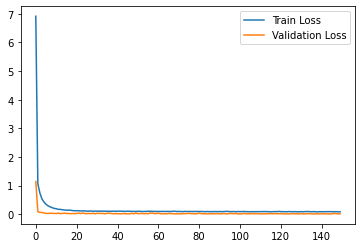

calculating for [True, True, True, False]
Restoring model weights from the end of the best epoch: 148.
Restoring model weights from the end of the best epoch: 145.
Restoring model weights from the end of the best epoch: 136.
Epoch 129: early stopping
Restoring model weights from the end of the best epoch: 89.
Epoch 143: early stopping
Restoring model weights from the end of the best epoch: 103.


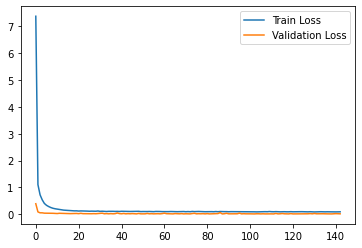

calculating for [True, True, False, True]
Epoch 104: early stopping
Restoring model weights from the end of the best epoch: 64.
Restoring model weights from the end of the best epoch: 122.
Epoch 127: early stopping
Restoring model weights from the end of the best epoch: 87.
Epoch 111: early stopping
Restoring model weights from the end of the best epoch: 71.
Epoch 114: early stopping
Restoring model weights from the end of the best epoch: 74.


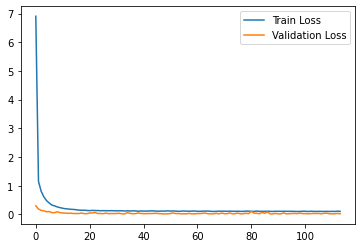

calculating for [True, True, False, False]
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 51.
Restoring model weights from the end of the best epoch: 140.
Epoch 137: early stopping
Restoring model weights from the end of the best epoch: 97.
Epoch 111: early stopping
Restoring model weights from the end of the best epoch: 71.
Epoch 118: early stopping
Restoring model weights from the end of the best epoch: 78.


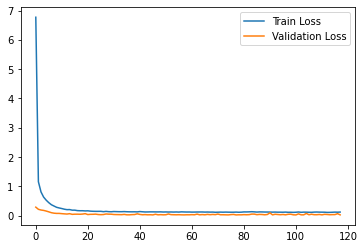

calculating for [True, False, True, True]
Epoch 135: early stopping
Restoring model weights from the end of the best epoch: 95.
Epoch 124: early stopping
Restoring model weights from the end of the best epoch: 84.
Restoring model weights from the end of the best epoch: 136.
Epoch 146: early stopping
Restoring model weights from the end of the best epoch: 106.
Restoring model weights from the end of the best epoch: 133.


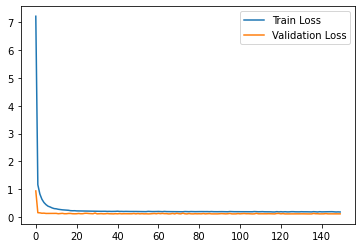

calculating for [True, False, True, False]
Epoch 133: early stopping
Restoring model weights from the end of the best epoch: 93.
Epoch 131: early stopping
Restoring model weights from the end of the best epoch: 91.
Epoch 82: early stopping
Restoring model weights from the end of the best epoch: 42.
Restoring model weights from the end of the best epoch: 130.
Epoch 150: early stopping
Restoring model weights from the end of the best epoch: 110.


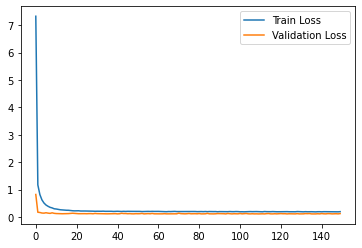

calculating for [True, False, False, True]
Epoch 111: early stopping
Restoring model weights from the end of the best epoch: 71.
Restoring model weights from the end of the best epoch: 140.
Epoch 115: early stopping
Restoring model weights from the end of the best epoch: 75.
Epoch 127: early stopping
Restoring model weights from the end of the best epoch: 87.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 43.


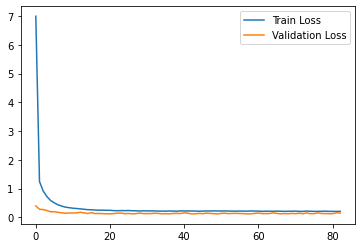

calculating for [True, False, False, False]
Epoch 141: early stopping
Restoring model weights from the end of the best epoch: 101.
Restoring model weights from the end of the best epoch: 145.
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 60.
Restoring model weights from the end of the best epoch: 141.
Epoch 123: early stopping
Restoring model weights from the end of the best epoch: 83.


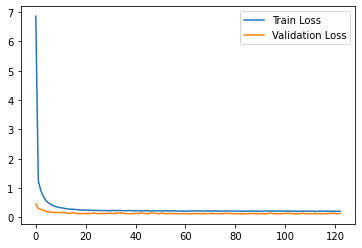

calculating for [False, True, True, True]
Epoch 114: early stopping
Restoring model weights from the end of the best epoch: 74.
Epoch 147: early stopping
Restoring model weights from the end of the best epoch: 107.
Epoch 123: early stopping
Restoring model weights from the end of the best epoch: 83.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 34.
Epoch 102: early stopping
Restoring model weights from the end of the best epoch: 62.


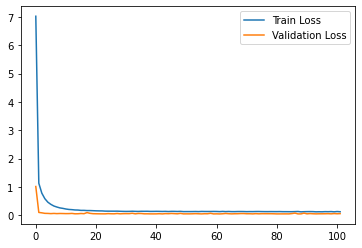

calculating for [False, True, True, False]
Epoch 140: early stopping
Restoring model weights from the end of the best epoch: 100.
Epoch 105: early stopping
Restoring model weights from the end of the best epoch: 65.
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 29.
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 60.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 43.


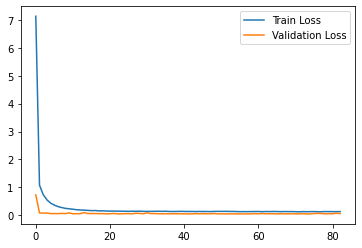

calculating for [False, True, False, True]
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 26.
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 47.
Epoch 124: early stopping
Restoring model weights from the end of the best epoch: 84.
Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 32.
Epoch 129: early stopping
Restoring model weights from the end of the best epoch: 89.


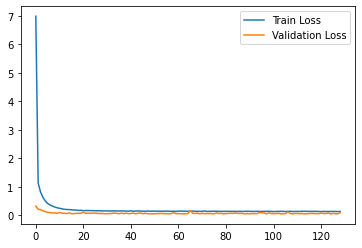

calculating for [False, True, False, False]
Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 58.
Epoch 120: early stopping
Restoring model weights from the end of the best epoch: 80.
Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 52.
Epoch 81: early stopping
Restoring model weights from the end of the best epoch: 41.
Epoch 67: early stopping
Restoring model weights from the end of the best epoch: 27.


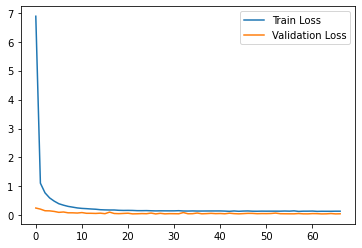

calculating for [False, False, True, True]
Epoch 112: early stopping
Restoring model weights from the end of the best epoch: 72.
Epoch 132: early stopping
Restoring model weights from the end of the best epoch: 92.
Epoch 103: early stopping
Restoring model weights from the end of the best epoch: 63.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 43.
Epoch 131: early stopping
Restoring model weights from the end of the best epoch: 91.


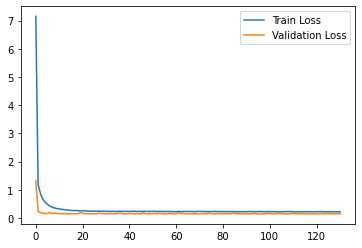

calculating for [False, False, True, False]
Restoring model weights from the end of the best epoch: 121.
Epoch 145: early stopping
Restoring model weights from the end of the best epoch: 105.
Restoring model weights from the end of the best epoch: 122.
Restoring model weights from the end of the best epoch: 121.
Epoch 67: early stopping
Restoring model weights from the end of the best epoch: 27.


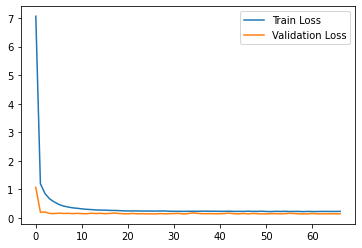

calculating for [False, False, False, True]
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 51.
Restoring model weights from the end of the best epoch: 111.
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 53.
Epoch 117: early stopping
Restoring model weights from the end of the best epoch: 77.
Epoch 114: early stopping
Restoring model weights from the end of the best epoch: 74.


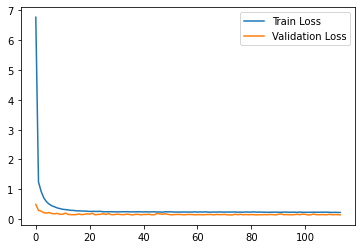

calculating for [False, False, False, False]
Epoch 146: early stopping
Restoring model weights from the end of the best epoch: 106.
Epoch 107: early stopping
Restoring model weights from the end of the best epoch: 67.
Restoring model weights from the end of the best epoch: 148.
Restoring model weights from the end of the best epoch: 118.
Epoch 131: early stopping
Restoring model weights from the end of the best epoch: 91.


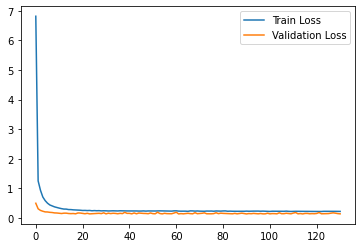

In [7]:
opties = [True, False]

results = pd.DataFrame(columns = ['add_country', 'add_gender', 'embed_age', 'embed_coun_gen', 'mean_train_loss', 'mean_val_loss', 'mean_test_loss'])

index = 0
n_runs = 5
epochs = 150

for add_country in opties:
    for add_gender in opties:
        for embed_age in opties:
            for embed_coun_gen in opties: 
                print(f'calculating for {[add_country, add_gender, embed_age, embed_coun_gen]}')
                
                # prepare training data (depending on which features and embeddings are included)
                X_train, Y_train = normalize_data(train, add_country, add_gender, embed_age, embed_coun_gen)
                X_test, Y_test = normalize_data(test_set, add_country, add_gender, embed_age, embed_coun_gen)
        
                train_loss, val_loss, score = np.zeros(n_runs), np.zeros(n_runs), np.zeros(n_runs)
                
                for run in range(n_runs):
                
                    model = build_model(add_country=add_country, add_gender=add_gender, embed_age=embed_age, embed_coun_gen=embed_coun_gen)
                    
                    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, restore_best_weights=True)
                    history = model.fit(x=X_train, y=Y_train, batch_size=128, epochs=epochs, verbose=0, validation_split=0.15,
                                       callbacks=[earlystop])
                
                    train_loss[run] = history.history['loss'][-1]
                    val_loss[run] = history.history['val_loss'][-1]
                    score[run] = model.evaluate(X_test, Y_test, verbose=0)
            
                results.loc[index] = [add_country, add_gender, embed_age, embed_coun_gen, train_loss.mean(), val_loss.mean(), score.mean()]
                index += 1
            
                plt.plot(history.history['loss'], label='Train Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.legend()
                plt.show()


In [8]:
results

,add_country,add_gender,embed_age,embed_coun_gen,mean_train_loss,mean_val_loss,mean_test_loss
0,True,True,True,True,0.090714,0.018553,0.566975
1,True,True,True,False,0.094456,0.019278,0.558420
2,True,True,False,True,0.105949,0.029179,0.569516
3,True,True,False,False,0.112993,0.031594,0.559493
4,True,False,True,True,0.187080,0.119089,0.653819
5,True,False,True,False,0.193079,0.118979,0.665032
6,True,False,False,True,0.204801,0.134181,0.652730
7,True,False,False,False,0.207388,0.132263,0.673964
8,False,True,True,True,0.121865,0.052421,0.616029
9,False,True,True,False,0.127300,0.060003,0.601868


In [9]:
results.to_excel("results_DAV.xlsx", index=False)

In [10]:
"""
X_train, Y_train = normalize_data(train)
X_test, Y_test = normalize_data(test_set)

model = build_model()
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, restore_best_weights=True)
history = model.fit(x=X_train, y=Y_train, batch_size=128, epochs=150, verbose=1, validation_split=0.15,
                   callbacks=[earlystop])
"""

"\nX_train, Y_train = normalize_data(train)\nX_test, Y_test = normalize_data(test_set)\n\nmodel = build_model()\nearlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, restore_best_weights=True)\nhistory = model.fit(x=X_train, y=Y_train, batch_size=128, epochs=150, verbose=1, validation_split=0.15,\n                   callbacks=[earlystop])\n"

In [11]:
"""
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
"""

"\nplt.plot(history.history['loss'], label='Train Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.legend()\nplt.show()\n"

In [12]:
"""
score = model.evaluate(X_test, Y_test, verbose=0)
print(model.metrics_names)
print(score)


# predictions on the test set: 
predic = model.predict(X_test)

test_set['prediction'] = predic
print(test_set)

plt.scatter(test_set['Age'], test_set['log_mortality'], label="Actual")
plt.scatter(test_set['Age'], test_set['prediction'], label="Predicted")
plt.legend()
plt.title('Prediction results for log(force of mortality)')
plt.xlabel('Age')
plt.ylabel('$\ln(\mu_x)$')
plt.show()
"""

'\nscore = model.evaluate(X_test, Y_test, verbose=0)\nprint(model.metrics_names)\nprint(score)\n\n\n# predictions on the test set: \npredic = model.predict(X_test)\n\ntest_set[\'prediction\'] = predic\nprint(test_set)\n\nplt.scatter(test_set[\'Age\'], test_set[\'log_mortality\'], label="Actual")\nplt.scatter(test_set[\'Age\'], test_set[\'prediction\'], label="Predicted")\nplt.legend()\nplt.title(\'Prediction results for log(force of mortality)\')\nplt.xlabel(\'Age\')\nplt.ylabel(\'$\\ln(\\mu_x)$\')\nplt.show()\n'

In [13]:
"""
# omzetting log(force of mortality) to mortality en plotten:
test_set['predic_mortality'] = np.exp(test_set['prediction'])
plt.scatter(test_set['Age'], test_set['mortality'], label="Actual")
plt.scatter(test_set['Age'], test_set['predic_mortality'], label="Predicted")
plt.title('Prediction results for force of mortality')
plt.xlabel('Age')
plt.ylabel('$\mu_x$')
plt.legend()
plt.show()
"""

'\n# omzetting log(force of mortality) to mortality en plotten:\ntest_set[\'predic_mortality\'] = np.exp(test_set[\'prediction\'])\nplt.scatter(test_set[\'Age\'], test_set[\'mortality\'], label="Actual")\nplt.scatter(test_set[\'Age\'], test_set[\'predic_mortality\'], label="Predicted")\nplt.title(\'Prediction results for force of mortality\')\nplt.xlabel(\'Age\')\nplt.ylabel(\'$\\mu_x$\')\nplt.legend()\nplt.show()\n'

In [14]:
"""
# Create the FacetGrid
g = sns.FacetGrid(test_set, col='Country', row='Year', margin_titles=True, height=4, aspect=0.7)

# Plot actual values
g.map_dataframe(sns.scatterplot, x='Age', y='log_mortality', s=30, label='actual')

# Loop through axes to add predicted values
for ax, (_, subset) in zip(g.axes.flat, test_set.groupby(['Country', 'Year'])):
    ax.scatter(subset['Age'], subset['prediction'], color='orange', label='prediction', s=20, alpha=0.5)  # Different color for prediction
    ax.axhline(y=-7.5, color='grey', linestyle='--', linewidth=1)
    ax.legend()

# Adjust labels
g.set_axis_labels("Age", "Log Mortality")

# Show plot
plt.show()
"""

'\n# Create the FacetGrid\ng = sns.FacetGrid(test_set, col=\'Country\', row=\'Year\', margin_titles=True, height=4, aspect=0.7)\n\n# Plot actual values\ng.map_dataframe(sns.scatterplot, x=\'Age\', y=\'log_mortality\', s=30, label=\'actual\')\n\n# Loop through axes to add predicted values\nfor ax, (_, subset) in zip(g.axes.flat, test_set.groupby([\'Country\', \'Year\'])):\n    ax.scatter(subset[\'Age\'], subset[\'prediction\'], color=\'orange\', label=\'prediction\', s=20, alpha=0.5)  # Different color for prediction\n    ax.axhline(y=-7.5, color=\'grey\', linestyle=\'--\', linewidth=1)\n    ax.legend()\n\n# Adjust labels\ng.set_axis_labels("Age", "Log Mortality")\n\n# Show plot\nplt.show()\n'